In [160]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

import tiff_file

%matplotlib notebook


Set the directory for where the data is below.

In [9]:
data_dir = ".\\ExampleData\\"
data_file = "23_osc_100gel_cooling_rollingbgsubtract-200_Bin2x2x2.tif"

In [104]:
images = tiff_file.imread(data_dir + data_file)
print "Number of frames in %s: %s" % (data_file, images.shape[0])

Number of frames in 23_osc_100gel_cooling_rollingbgsubtract-200_Bin2x2x2.tif: 288


Below we define the function for 2D image autocorrelation

In [105]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

In [136]:
def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print "ax must be 0 or 1"
        return 0
    
    std_devs = data.std(axis=ax)
    #print "shape of std_devs: ", std_devs.shape #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[temp.shape[0]/2:]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[temp.shape[1]/2:]

In [173]:
def find_where_corr_at_half(corr):
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x)
    min_index = np.argmin(abs(eval_at_new_x-0.5))
    return new_x[min_index]

<IPython.core.display.Javascript object>


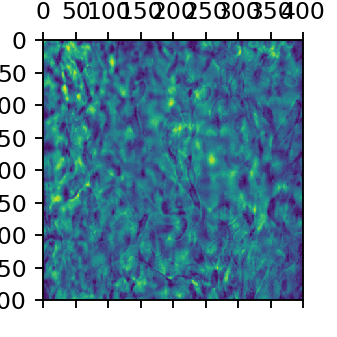

<IPython.core.display.Javascript object>


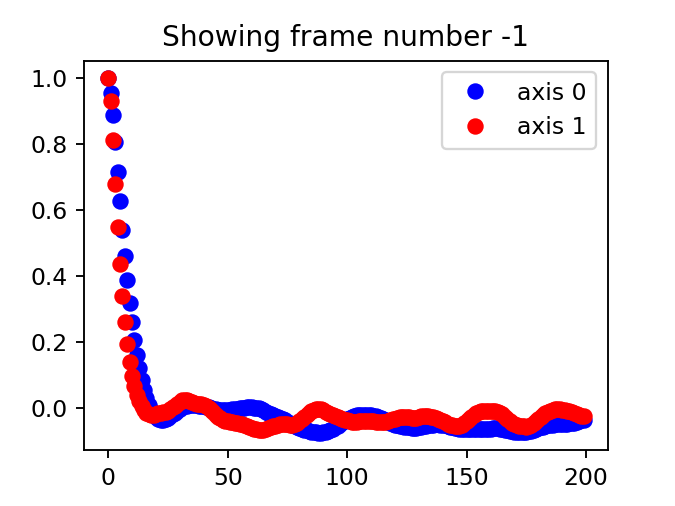

Where the correlation goes to 50% for axis 0:  6.503251625812906
Where the correlation goes to 50% for axis 1:  4.402201100550275


In [179]:
frame_to_show = -1
im = images[frame_to_show]
plt.figure(figsize=(2,2))
plt.matshow(im, fignum=0)
corr2d = autocorrelation_2D(im)
plt.figure(figsize=(4,3))
acorr_0 = autocorrelation_1D(im,0)
acorr_1 = autocorrelation_1D(im,1)
plt.plot(acorr_0,'bo',label='axis 0')
plt.plot(acorr_1,'ro',label='axis 1')
#plt.plot(corr2d[im.shape[0]/2,im.shape[1]/2:], 'go')
#plt.plot(corr2d[im.shape[0]/2:,im.shape[1]/2], 'mo')
print "Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(acorr_0)
print "Where the correlation goes to 50% for axis 1: ", find_where_corr_at_half(acorr_1)
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)

Below, we will loop over all frames in the movie and find where the autocorrelation along x and along y reaches 0.5 (50% of the maximum).

In [181]:
xCorr50 = np.zeros(images.shape[0])
yCorr50 = np.zeros_like(xCorr50)
for i in range(images.shape[0]):
    xc = autocorrelation_1D(images[i], 0)
    yc = autocorrelation_1D(images[i], 1)
    xCorr50[i] = find_where_corr_at_half(xc)
    yCorr50[i] = find_where_corr_at_half(yc)


<IPython.core.display.Javascript object>


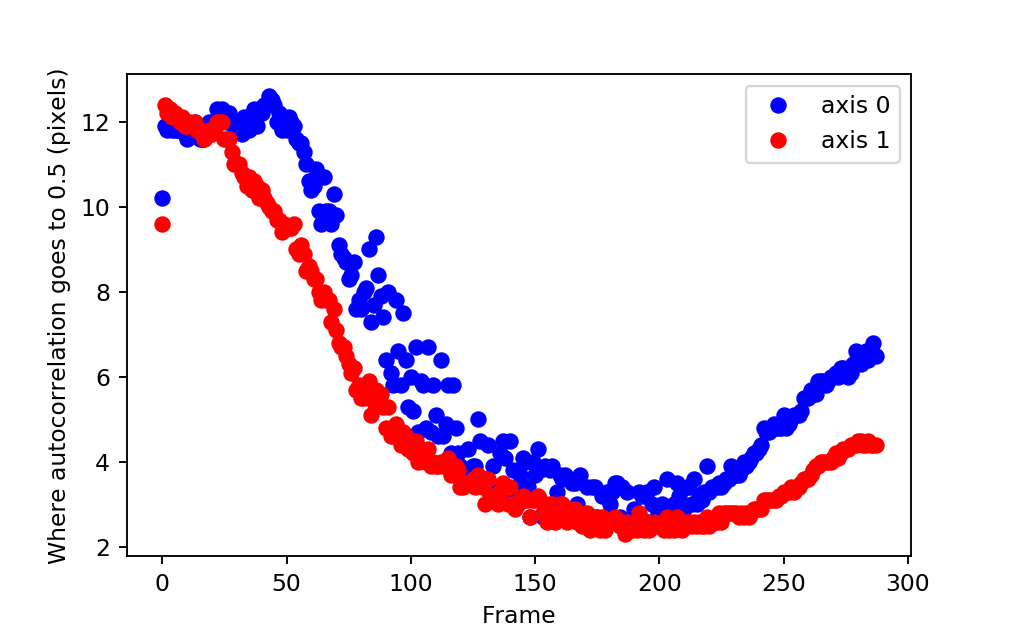

In [183]:
fig = plt.figure(figsize=(6,6/1.618))
plt.plot(xCorr50, 'bo', label="axis 0")
plt.plot(yCorr50, 'ro', label="axis 1")
plt.xlabel("Frame")
plt.ylabel("Where autocorrelation goes to 0.5 (pixels)")
plt.legend(loc=0)